<https://github.com/PolymathicAI/xVal>


In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

In [2]:
import jax.numpy as jnp  # Oddly works in colab to set gpu

arr = jnp.array([1, 2, 3])
arr.devices()

{CpuDevice(id=0)}

In [3]:
import icecream
from icecream import ic

icecream.install()
ic_disable = False
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)

In [4]:
import os
import ast

from datetime import datetime as dt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import hephaestus as hp
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
from flax.training import train_state
from icecream import ic
from jax import random
from flax import struct
from jax.tree_util import tree_flatten
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from hephaestus.models.simple_time_series import SimpleDS

pd.options.mode.copy_on_write = True

In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        print("Concatenating dfs...")
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")

In [7]:
# Get min, mean, and max number of time steps
df.groupby("idx").count().time_step.agg(["min", "mean", "max"])

min     30.000000
mean    44.511656
max     59.000000
Name: time_step, dtype: float64

In [8]:
# class SimpleDS(Dataset):
#     def __init__(self, df, custom_attention: bool = True):
#         # Add nan padding to make sure all sequences are the same length
#         # use the idx column to group by
#         self.max_seq_len = df.groupby("idx").count().time_step.max()
#         self.custom_attention = custom_attention
#         self.df = df
#         self.batch_size = self.max_seq_len

#         self.special_tokens = ["[PAD]", "[NUMERIC_MASK]", "[MASK]"]
#         self.cat_mask = "[MASK]"
#         self.numeric_mask = "[NUMERIC_MASK]"

#         self.col_tokens = [col_name for col_name in df.columns if col_name != "idx"]

#         self.tokens = self.special_tokens + self.col_tokens

#         self.token_dict = {token: i for i, token in enumerate(self.tokens)}
#         self.token_decoder_dict = {i: token for i, token in enumerate(self.tokens)}
#         self.n_tokens = len(self.tokens)
#         self.numeric_indices = jnp.array(
#             [self.tokens.index(i) for i in self.col_tokens]
#         )

#         self.numeric_mask_token = self.tokens.index(self.numeric_mask)

#     def __len__(self):
#         return self.df.idx.max() + 1  # probably should be max idx + 1 thanks

#     def __getitem__(self, set_idx):
#         batch = self.df.loc[
#             self.df.idx == set_idx, [col for col in self.df.columns if col != "idx"]
#         ]
#         batch = np.array(batch.values)
#         # Add padding
#         batch_len, n_cols = batch.shape
#         pad_len = self.max_seq_len - batch_len
#         padding = np.full((pad_len, n_cols), jnp.nan)
#         batch = np.concatenate([batch, padding], axis=0)
#         return batch

In [9]:
# Get train test split at 80/20
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
del df
train_ds = SimpleDS(train_df)
test_ds = SimpleDS(test_df)

In [10]:
def make_batch(ds: SimpleDS, start: int, length: int):
    data = []
    for i in range(start, length + start):
        data.append(ds[i])

    return jnp.array(data)


batch = make_batch(train_ds, 0, 4)

In [11]:
time_series_regressor = hp.simple_time_series.SimplePred(train_ds, d_model=64 * 4)

In [12]:
key = random.PRNGKey(0)
init_key, dropout_key = random.split(key)
vars = time_series_regressor.init(
    {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
)
dropout_key, original_dropout_key = random.split(dropout_key)
x = time_series_regressor.apply(
    vars, batch, deterministic=False, rngs={"dropout": dropout_key}
)

ValueError: Incompatible shapes for broadcasting: shapes=[(4, 59, 59), (4, 59, 4, 26, 26), ()]

In [ ]:
time_series_regressor.tabulate(
    {"params": init_key, "dropout": dropout_key},
    batch,
    console_kwargs={"force_jupyter": True, "width": 120},
)

                                                   SimplePred Summary                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module                ┃ inputs                ┃ outputs               ┃ params               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ SimplePred            │ float32[4,59,26]      │ float32[4,59,26]      │                      │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┤
│ TimeSeriesTransforme… │ TimeSeriesTransformer │ deterministic: False  │ float32[4,59,26,272]  │                      │
│                       │                       │ numeric_inputs:       │                       │                      │
│                       │                       │ float32[4,59,26]      │                       │                      │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┤
│ TimeSeriesTransforme… │ Embed                 │ int32[26]             │ float32[26,256]       │ embedding:           │
│                       │                       │                       │                       │ float32[29,256]      │
│                       │                       │                       │                       │                      │
│                       │                       │                       │                       │ 7,424 (29.7 KB)      │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┤
│ TimeSeriesTransforme… │ PositionalEncoding    │ float32[4,59,26,256]  │ float32[4,59,26,272]  │                      │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┤
│ TimeSeriesTransforme… │ TransformerBlock      │ deterministic: False  │ float32[4,59,26,272]  │                      │
│                       │                       │ k:                    │                       │                      │
│                       │                       │ float32[4,59,26,256]  │                       │                      │
│                       │                       │ q:                    │                       │                      │
│                       │                       │ float32[4,59,26,272]  │                       │                      │
│                       │                       │ v:                    │                       │                      │
│                       │                       │ float32[4,59,26,272]  │                       │                      │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┤
│ TimeSeriesTransforme… │ MultiHeadDotProductA… │ -                     │ float32[4,59,26,272]  │                      │
│                       │                       │ float32[4,59,26,272]  │                       │                      │
│                       │                       │ -                     │                       │                      │
│                       │                       │ float32[4,59,26,256]  │                       │                      │
│                       │                       │ -                     │                       │                      │
│                       │                       │ float32[4,59,26,272]  │                       │                      │
│                       │                       │ - deterministic:      │                       │                      │
│                       │                       │ False                 │                       │                      │
│      

'\n\n'

In [ ]:
def calculate_memory_footprint(params):
    """Calculate total memory footprint of JAX model parameters and total
    number of parameters."""
    total_bytes = 0
    # Flatten the parameter tree structure into a list of arrays
    flat_params, _ = tree_flatten(params)
    for param in flat_params:
        # Calculate bytes: number of elements * size of each element
        bytes_per_param = param.size * param.dtype.itemsize
        total_bytes += bytes_per_param
    return total_bytes


def count_parameters(params):
    return sum(jnp.prod(jnp.array(p.shape)) for p in jax.tree_util.tree_leaves(params))


mem = calculate_memory_footprint(vars)
total_params = count_parameters(vars)


print(f"Memory of custom: {mem / 1e6:.2f} MB with {total_params:,} parameters")

Memory of custom: 3.24 MB with 809,889 parameters


In [ ]:
batch.shape

(4, 59, 26)

In [ ]:
def create_causal_mask(tensor: jnp.ndarray):
    """Create a causal mask to mask out future values."""
    mask = jnp.tril(jnp.ones((tensor.shape[0], tensor.shape[1])))
    return mask


def create_padding_mask(tensor: jnp.ndarray):
    """Create a padding mask to mask out padded values."""
    mask = jnp.isnan(tensor)
    return mask


def mask_array(tensor: jnp.array):
    """Create a mask for the tensor"""
    causal_mask = create_causal_mask(tensor)
    padding_mask = create_padding_mask(tensor)
    mask = jnp.logical_or(causal_mask, padding_mask)
    return mask

In [ ]:
jnp.array(train_ds[0]).shape

(59, 26)

In [ ]:
from flax import linen as nn

?nn.make_attention_mask

Signature:
nn.make_attention_mask(
    query_input: Union[jax.Array, Any],
    key_input: Union[jax.Array, Any],
    pairwise_fn: Callable[..., Any] = <PjitFunction of <function jax.numpy.multiply at 0x12b55f250>>,
    extra_batch_dims: int = 0,
    dtype: Union[str, type[Any], numpy.dtype, jax._src.typing.SupportsDType, Any] = <class 'jax.numpy.float32'>,
)
Docstring:
Mask-making helper for attention weights.

In case of 1d inputs (i.e., ``[batch..., len_q]``, ``[batch..., len_kv]``, the
attention weights will be ``[batch..., heads, len_q, len_kv]`` and this
function will produce ``[batch..., 1, len_q, len_kv]``.

Args:
  query_input: a batched, flat input of query_length size
  key_input: a batched, flat input of key_length size
  pairwise_fn: broadcasting elementwise comparison function
  extra_batch_dims: number of extra batch dims to add singleton axes for, none
    by default
  dtype: mask return dtype

Returns:
  A ``[batch..., 1, len_q, len_kv]`` shaped mask for 1d attention.
F

In [ ]:
nn.make_attention_mask(
    jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    jnp.array([1, 2, 3, 4, 5]),
)

Array([[[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 3.,  6.,  9., 12., 15.],
        [ 4.,  8., 12., 16., 20.],
        [ 5., 10., 15., 20., 25.],
        [ 6., 12., 18., 24., 30.],
        [ 7., 14., 21., 28., 35.],
        [ 8., 16., 24., 32., 40.],
        [ 9., 18., 27., 36., 45.],
        [10., 20., 30., 40., 50.]]], dtype=float32)

In [ ]:
mts_root_key = random.PRNGKey(44)
mts_main_key, ts_params_key, ts_data_key = random.split(mts_root_key, 3)


def clip_gradients(gradients, max_norm):
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(grad)) for grad in gradients.values()))
    scale = max_norm / (total_norm + 1e-6)
    clipped_gradients = jax.tree_map(
        lambda grad: jnp.where(total_norm > max_norm, grad * scale, grad), gradients
    )
    return clipped_gradients


def base_loss(inputs, outputs):
    # Create mask for nan inputs
    nan_mask = jnp.isnan(inputs)
    inputs = jnp.where(nan_mask, jnp.zeros_like(inputs), inputs)
    outputs = jnp.where(nan_mask, jnp.zeros_like(outputs), outputs)

    raw_loss = optax.squared_error(outputs, inputs)
    masked_loss = jnp.where(nan_mask, 0.0, raw_loss)
    loss = masked_loss.sum() / (~nan_mask).sum()

    return loss


def calculate_loss(params, state, inputs, dataset: SimpleDS, dropout_key, mask_key):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        rngs={"dropout": dropout_key},
        deterministic=False,
    )
    loss = base_loss(inputs, outputs)
    # Create mask for nan inputs

    return loss


@jax.jit
def train_step(state: train_state.TrainState, batch, base_key):
    dropout_key, mask_key, new_key = jax.random.split(base_key, 3)

    def loss_fn(params):
        return calculate_loss(params, state, batch, train_ds, dropout_key, mask_key)

    grad_fn = jax.value_and_grad(loss_fn)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss, grad = grad_fn(state.params)
    # grad = replace_nans(grad)
    # grad = clip_gradients(grad, 1.0)
    state = state.apply_gradients(grads=grad)

    return state, loss, new_key


def evaluate(params, state, inputs, dataset: SimpleDS, dropout_key, mask_key):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        deterministic=True,
    )
    loss = base_loss(inputs, outputs)
    return loss


@jax.jit
def eval_step(state: train_state.TrainState, batch, base_key):
    mask_key, dropout_key, new_key = jax.random.split(base_key, 3)

    def loss_fn(params):
        return evaluate(params, state, batch, train_ds, dropout_key, mask_key)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss = loss_fn(state.params)
    return loss, new_key


def create_train_state(model, prng, batch, lr):
    init_key, dropout_key = random.split(prng)
    params = model.init(
        {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
    )
    # optimizer = optax.chain(optax.adam(lr))
    optimizer = optax.chain(optax.clip_by_global_norm(0.4), optax.adam(lr))
    # optimizer_state = optimizer.init(params)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params["params"],
        tx=optimizer,
        # tx_state=optimizer_state,
    )


batch_size = 2
# batch = train_ds[0]
# state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)
state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)

In [ ]:
writer_name = "CausalMask"

writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")

train_summary_writer = SummaryWriter("runs/" + writer_time + writer_name)


test_set_key = random.PRNGKey(4454)

train_data_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=512, shuffle=True)
batch_count = 0
base_key = random.PRNGKey(42)

for j in trange(1, desc=f"epochs for {train_summary_writer.log_dir}"):
    # arrs = train_data_loader()
    for i in tqdm(train_data_loader, leave=False, desc="batches"):
        # for i in trange(len(pre_train) // batch_size, leave=False):
        # for i in trange(len(pre_train) // batch_size //10, leave=False):
        # batch = make_batch(train_ds, i[0], 4)

        state, loss, base_key = train_step(state, jnp.array(i), base_key)
        if jnp.isnan(loss):
            raise ValueError("Nan Value in loss, stopping")
        batch_count += 1

        if batch_count % 1 == 0:
            train_summary_writer.add_scalar(
                "loss/loss", np.array(loss.item()), batch_count
            )
        if batch_count % 10 == 0:
            test_loss, base_key = eval_step(
                state, jnp.array(next(iter(test_data_loader))), base_key
            )
            train_summary_writer.add_scalar(
                "loss/test_loss", np.array(test_loss.item()), batch_count
            )

train_summary_writer.close()

epochs for runs/2024-05-23T17:17:21CausalMask:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
from jax import random

test_key = jax.random.key(12)
att = random.normal(test_key, (2, 10, 6, 16))

In [ ]:
def return_results(state, dataset, key):
    outputs = state.apply_fn(
        {"params": state.params},
        # hp.mask_tensor(jnp.array([train_ds[0]]), dataset, prng_key=key),
        jnp.array([dataset[0]]),
        deterministic=True,
    )
    return outputs


# test_result = jnp.squeeze(
#     state.apply_fn({"params": state.params}, jnp.array([train_ds[0]]))
# )
test_result = return_results(state, train_ds, test_key)
test_result.shape

(1, 59, 26)

In [ ]:
jnp.squeeze(test_result).shape

(59, 26)

In [ ]:
test_result = jnp.squeeze(test_result)
df_pred = pd.DataFrame(test_result)
df_actual = pd.DataFrame(train_ds[0])

In [ ]:
df_pred.head().shape, train_df.head().shape

((5, 26), (5, 27))

In [ ]:
df_pred.columns = train_df.drop("idx", axis=1).columns
df_actual.columns = train_df.drop("idx", axis=1).columns

In [ ]:
df_actual

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674530,2.825381,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pred

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,-0.129779,1.276990,-1.113853,0.466538,0.584730,0.772767,2.230249,1.278194,1.708518,1.507068,...,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018,-0.639018
1,0.230372,1.296181,-0.785724,0.045093,0.736830,0.486601,2.369161,1.222250,1.701897,1.493344,...,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599,-0.541599
2,0.702104,1.353345,-0.363297,-0.301331,0.800037,0.275401,2.452332,1.148241,1.765875,1.395555,...,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309,-0.522309
3,1.286389,1.520669,0.054826,-0.691738,0.740064,-0.056749,2.415805,1.139834,1.826742,1.365391,...,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973,-0.660973
4,1.719420,1.463765,0.388306,-1.070150,0.295924,-0.387331,2.406039,1.061205,1.893298,1.529187,...,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054,-0.557054
5,2.137065,1.219271,0.667881,-1.247213,-0.196632,-0.669946,2.397131,1.135307,1.912996,1.670964,...,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889,-0.667889
6,2.631853,1.086166,0.956922,-1.021363,-0.608486,-0.937920,2.407536,1.133973,1.855832,1.674547,...,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146,-0.720146
7,3.077583,0.858803,1.199127,-0.742976,-1.070087,-1.178423,2.345323,1.076176,1.702887,1.605244,...,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299,-0.654299
8,3.487717,0.713117,1.407663,-0.363890,-1.277772,-1.372497,2.276455,1.187819,1.781125,1.641924,...,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838,-0.494838
9,3.890983,0.405671,1.473674,0.062575,-1.231541,-1.604967,2.176264,1.172601,1.831603,1.505546,...,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024,-0.489024


In [ ]:
# Subtract the actual from the predicted
df_diff = df_pred - df_actual
df_diff

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,-0.129779,-0.283071,-0.259416,-0.254101,-0.106999,-0.171241,-0.470383,-0.034368,-0.235745,-0.390739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.234744,-0.393677,-0.271366,-0.288201,-0.205459,-0.195003,-0.416649,-0.090312,-0.242366,-0.404463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.228129,-0.400244,-0.209089,-0.176335,-0.192331,-0.137551,-0.393129,-0.164321,-0.178387,-0.502252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.108960,-0.227399,-0.157196,-0.134963,-0.091663,-0.197289,-0.463427,-0.172728,-0.117520,-0.532415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.141045,-0.209807,-0.181598,-0.199570,-0.198887,-0.254187,-0.480979,-0.251357,-0.050965,-0.368620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.188516,-0.314540,-0.237726,-0.247062,-0.249810,-0.264308,-0.471818,-0.177255,-0.031267,-0.226843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.158845,-0.249360,-0.249911,-0.103172,-0.208799,-0.263390,-0.417845,-0.178589,-0.088431,-0.223260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.178231,-0.229022,-0.264386,-0.100996,-0.302129,-0.240949,-0.411566,-0.236386,-0.241375,-0.292563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.233213,-0.088247,-0.260541,-0.134082,-0.304257,-0.180285,-0.387802,-0.124743,-0.163138,-0.255883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.295064,-0.081878,-0.342495,-0.168517,-0.259092,-0.168382,-0.372194,-0.139961,-0.112660,-0.392261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
model_name = f"big_train_{dt.now()}_"

current_dir = os.getcwd()

if not os.path.exists("./pre_trained_models/"):
    os.makedirs("./pre_trained_models/")

path = os.path.join(current_dir, "./pre_trained_models/")


ckpt_dir = f"./pre_trained_models/{model_name}"

# checkpoints.save_checkpoint(
#     ckpt_dir=path, target=state, step=batch_count, overwrite=True, prefix=model_name
# )

In [ ]:
import jax.numpy as jnp
from flax import linen as nn


class FeedForwardNetwork(nn.Module):
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, deterministic: bool):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
        x = nn.Dense(self.d_model)(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
        return x


class TransformerBlock(nn.Module):
    num_heads: int
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, deterministic: bool):
        # Generate the causal mask using make_causal_mask
        causal_mask = nn.make_causal_mask(
            x[:, :, 0], dtype=jnp.float32
        )  # shape: (batch, 1, seq_len, seq_len)
        print(f"First x shape: {x.shape}, causal_mask shape: {causal_mask.shape}")
        # Multi-head self-attention with causal mask
        attention = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            dropout_rate=self.dropout_rate,
            broadcast_dropout=False,
        )(x, x, mask=causal_mask, deterministic=deterministic)
        print(f"X Final Shape: {x.shape}")
        x = x + attention
        print(f"X + Attention Shape: {x.shape}")
        print(x)
        x = nn.LayerNorm()(x)

        # Feed Forward Network
        ffn = FeedForwardNetwork(
            d_model=self.d_model, d_ff=self.d_ff, dropout_rate=self.dropout_rate
        )(x, deterministic=deterministic)

        x = x + ffn
        x = nn.LayerNorm()(x)

        return x


# Example usage:
class Transformer(nn.Module):
    num_layers: int
    num_heads: int
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, deterministic: bool):
        for _ in range(self.num_layers):
            x = TransformerBlock(
                num_heads=self.num_heads,
                d_model=self.d_model,
                d_ff=self.d_ff,
                dropout_rate=self.dropout_rate,
            )(x, deterministic=deterministic)
        return x


# Dummy input for demonstration
x = jnp.ones((1, 20, 512))  # Batch size: 1, Sequence length: 20, Model dimension: 512

# Create the model instance
model = Transformer(num_layers=2, num_heads=8, d_model=512, d_ff=2048, dropout_rate=0.1)

# Initialize parameters
variables = model.init(jax.random.PRNGKey(0), x, deterministic=True)

# Apply the model
output = model.apply(variables, x, deterministic=True)

First x shape: (1, 20, 512), causal_mask shape: (1, 1, 20, 20)
X Final Shape: (1, 20, 512)
X + Attention Shape: (1, 20, 512)
[[[2.2598886  1.763012   0.49513417 ... 1.458744   1.3766336  0.28646338]
  [2.2598886  1.763012   0.49513417 ... 1.458744   1.3766336  0.28646338]
  [2.2598886  1.763012   0.49513412 ... 1.458744   1.3766339  0.28646338]
  ...
  [2.2598886  1.7630117  0.495134   ... 1.458744   1.3766335  0.28646338]
  [2.2598891  1.763012   0.495134   ... 1.4587443  1.3766336  0.28646314]
  [2.2598886  1.7630124  0.49513382 ... 1.4587442  1.3766336  0.28646314]]]
First x shape: (1, 20, 512), causal_mask shape: (1, 1, 20, 20)
X Final Shape: (1, 20, 512)
X + Attention Shape: (1, 20, 512)
[[[ 3.1042538  -1.2391928  -2.27371    ...  1.3665593  -0.4227026
    0.98595935]
  [ 3.1042538  -1.2391928  -2.27371    ...  1.3665593  -0.4227026
    0.98595935]
  [ 3.104254   -1.2391927  -2.2737103  ...  1.3665593  -0.4227022
    0.9859587 ]
  ...
  [ 3.1042542  -1.2391931  -2.273711   ...  1.

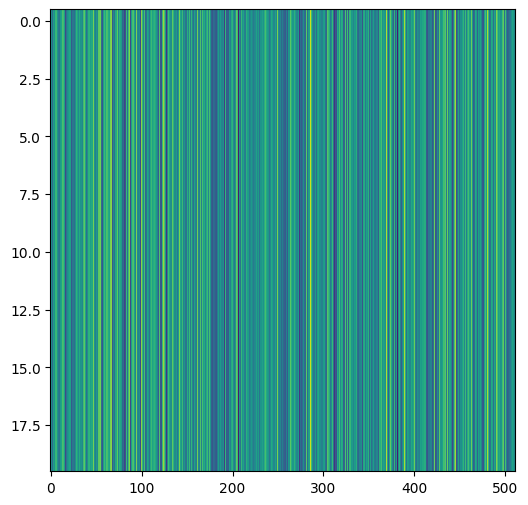

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(output[0], cmap="viridis", aspect="auto")

In [ ]:
nn.make_causal_mask(x[:, :, 0], dtype=jnp.float32)

Array([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
          0., 0., 0.,

In [ ]:
(jnp.arange(59) < 50).astype(jnp.float32)[None, :]

Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
import jax.numpy as jnp
from flax import linen as nn


class FeedForwardNetwork(nn.Module):
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, deterministic: bool):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
        x = nn.Dense(self.d_model)(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
        return x


class TransformerBlock(nn.Module):
    num_heads: int
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, time_padding_mask, col_padding_mask, deterministic: bool):
        # Generate the causal mask for the time dimension
        causal_mask = nn.make_causal_mask(
            x[:, :, 0, 0], dtype=jnp.float32
        )  # shape: (batch, 1, time_steps, time_steps)

        # Generate the time padding mask using make_attention_mask
        time_padding_mask = nn.make_attention_mask(
            time_padding_mask, time_padding_mask, dtype=jnp.float32
        )  # shape: (batch, 1, time_steps, time_steps)

        # Combine the causal mask and the time padding mask
        combined_time_mask = jnp.logical_and(causal_mask, time_padding_mask).astype(
            jnp.float32
        )  # shape: (batch, 1, time_steps, time_steps)

        # Generate the column padding mask
        col_padding_mask = col_padding_mask[
            :, None, :, None
        ]  # shape: (batch, 1, columns, 1)

        # Apply the column padding mask to the attention weights
        col_padding_mask = nn.make_attention_mask(
            col_padding_mask, col_padding_mask, dtype=jnp.float32
        )  # shape: (batch, 1, columns, columns)

        # Expand the combined time mask to match the dimensions required by the
        # attention mechanism
        combined_time_mask = combined_time_mask[
            :, :, :, None, None
        ]  # shape: (batch, 1, time_steps, 1, 1)

        # Combine the time and column masks
        combined_mask = (
            combined_time_mask * col_padding_mask[:, None, None, :, :]
        )  # shape: (batch, 1, time_steps, columns, columns)

        # Multi-head self-attention with combined mask
        attention = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            dropout_rate=self.dropout_rate,
            broadcast_dropout=False,
        )(x, x, mask=combined_mask, deterministic=deterministic)

        x = x + attention
        x = nn.LayerNorm()(x)

        # Feed Forward Network
        ffn = FeedForwardNetwork(
            d_model=self.d_model, d_ff=self.d_ff, dropout_rate=self.dropout_rate
        )(x, deterministic=deterministic)

        x = x + ffn
        x = nn.LayerNorm()(x)

        return x


# Example usage:
class Transformer(nn.Module):
    num_layers: int
    num_heads: int
    d_model: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, time_padding_mask, col_padding_mask, deterministic: bool):
        for _ in range(self.num_layers):
            x = TransformerBlock(
                num_heads=self.num_heads,
                d_model=self.d_model,
                d_ff=self.d_ff,
                dropout_rate=self.dropout_rate,
            )(x, time_padding_mask, col_padding_mask, deterministic=deterministic)
        return x


# Dummy input for demonstration
x = jnp.ones(
    (4, 59, 26, 272)
)  # Batch size: 4, Time steps: 59, Columns: 26, Embedding dimension: 272
time_padding_mask = (jnp.arange(59) < 50).astype(jnp.float32)[
    None, :
]  # Mask first 50 time steps
col_padding_mask = (jnp.arange(26) < 20).astype(jnp.float32)[
    None, :
]  # Mask first 20 columns

# Create the model instance
model = Transformer(num_layers=2, num_heads=8, d_model=272, d_ff=1024, dropout_rate=0.1)

# Initialize parameters
variables = model.init(
    jax.random.PRNGKey(0), x, time_padding_mask, col_padding_mask, deterministic=True
)

# Apply the model
output = model.apply(
    variables, x, time_padding_mask, col_padding_mask, deterministic=True
)

ValueError: Incompatible shapes for broadcasting: shapes=[(4, 1, 59, 1, 1, 59), (1, 1, 1, 1, 26, 1, 1, 1)]

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn


def create_attention_mask(batch_size, time_steps, columns):
    # Assume these are your masks for time_steps and columns
    # They should have the shape (batch_size, time_steps) and (batch_size, columns) respectively
    time_steps_mask = jnp.ones(
        (batch_size, time_steps), dtype=bool
    )  # Change as per your mask
    columns_mask = jnp.ones(
        (batch_size, columns), dtype=bool
    )  # Change as per your mask

    # Expand dimensions to match (batch_size, time_steps, columns)
    time_steps_mask_expanded = jnp.expand_dims(
        time_steps_mask, axis=-1
    )  # Shape: (batch_size, time_steps, 1)
    columns_mask_expanded = jnp.expand_dims(
        columns_mask, axis=-2
    )  # Shape: (batch_size, 1, columns)

    # Combine masks: logical AND to create the final mask
    attention_mask = (
        time_steps_mask_expanded & columns_mask_expanded
    )  # Shape: (batch_size, time_steps, columns)

    return attention_mask


# Example usage
batch_size = 2
time_steps = 3
columns = 4

attention_mask = create_attention_mask(batch_size, time_steps, columns)
print(attention_mask)

[[[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]]


In [ ]:
?nn.make_attention_mask

Signature:
nn.make_attention_mask(
    query_input: Union[jax.Array, Any],
    key_input: Union[jax.Array, Any],
    pairwise_fn: Callable[..., Any] = <PjitFunction of <function jax.numpy.multiply at 0x1178b3520>>,
    extra_batch_dims: int = 0,
    dtype: Union[str, type[Any], numpy.dtype, jax._src.typing.SupportsDType, Any] = <class 'jax.numpy.float32'>,
)
Docstring:
Mask-making helper for attention weights.

In case of 1d inputs (i.e., ``[batch..., len_q]``, ``[batch..., len_kv]``, the
attention weights will be ``[batch..., heads, len_q, len_kv]`` and this
function will produce ``[batch..., 1, len_q, len_kv]``.

Args:
  query_input: a batched, flat input of query_length size
  key_input: a batched, flat input of key_length size
  pairwise_fn: broadcasting elementwise comparison function
  extra_batch_dims: number of extra batch dims to add singleton axes for, none
    by default
  dtype: mask return dtype

Returns:
  A ``[batch..., 1, len_q, len_kv]`` shaped mask for 1d attention.
F

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn

# Example inputs
batch_size = 2
query_length = 3
key_length = 4

# Dummy query and key inputs with batch and sequence lengths
query_input = jnp.array([[1, 1, 1], [1, 0, 1]])  # Shape: (batch_size, query_length)
key_input = jnp.array([[1, 1, 1, 1], [1, 1, 0, 1]])  # Shape: (batch_size, key_length)

# Create attention mask
attention_mask = nn.make_attention_mask(query_input, key_input)

print(attention_mask)

[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 0. 1.]
   [0. 0. 0. 0.]
   [1. 1. 0. 1.]]]]


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen


def create_combined_attention_mask(time_steps_mask, columns_mask):
    # Expand dimensions to match (batch_size, time_steps, columns)
    time_steps_mask_expanded = jnp.expand_dims(
        time_steps_mask, axis=-1
    )  # Shape: (batch_size, time_steps, 1)
    columns_mask_expanded = jnp.expand_dims(
        columns_mask, axis=-2
    )  # Shape: (batch_size, 1, columns)

    # Combine masks: logical AND to create the final mask
    combined_mask = (
        time_steps_mask_expanded & columns_mask_expanded
    )  # Shape: (batch_size, time_steps, columns)

    # Flatten masks for nn.make_attention_mask
    combined_mask_flat = combined_mask.reshape(combined_mask.shape[0], -1)

    return combined_mask_flat


# Example inputs
batch_size = 2
time_steps = 3
columns = 4

# Example masks
time_steps_mask = jnp.array([[1, 1, 0], [1, 0, 1]])  # Shape: (batch_size, time_steps)
columns_mask = jnp.array([[1, 0, 1, 1], [1, 1, 0, 1]])  # Shape: (batch_size, columns)

# Create combined attention mask
combined_mask = create_combined_attention_mask(time_steps_mask, columns_mask)

# Create attention mask using nn.make_attention_mask
attention_mask = nn.make_attention_mask(combined_mask, combined_mask)

print(attention_mask)
print(attention_mask.shape)

[[[[1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


 [[[1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
   [1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
   [1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]]]]
(2, 1, 12

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn


class SimpleDecoder(nn.Module):
    vocab_size: int
    hidden_size: int
    num_heads: int

    @nn.compact
    def __call__(self, x):
        # x is the input sequence of token ids
        embeddings = nn.Embed(self.vocab_size, self.hidden_size)(x)
        seq_len = x.shape[1]

        # Create a causal mask
        causal_mask = nn.make_causal_mask(jnp.ones((seq_len, seq_len), dtype=bool))

        # Apply multi-head attention
        attn_output = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)(
            embeddings, embeddings, embeddings, mask=causal_mask
        )

        # Predict the next token
        logits = nn.Dense(self.vocab_size)(attn_output)
        return logits, attn_output, causal_mask


# Define the model
vocab_size = 10000  # Example vocabulary size
hidden_size = 512  # Example hidden size
num_heads = 8  # Example number of attention heads

model = SimpleDecoder(
    vocab_size=vocab_size, hidden_size=hidden_size, num_heads=num_heads
)

# Example input
input_tokens = jnp.array([[1, 2, 3, 4, 5]])  # Example token ids
rng = jax.random.PRNGKey(0)

# Initialize parameters
params = model.init(rng, input_tokens)

# Forward pass
logits, attn_output, causal_mask = model.apply(params, input_tokens)
# print(logits)

In [ ]:
causal_mask.shape

(5, 1, 5, 5)